In [1]:
from rateslib import *

# Constructing Curves from (CC) Zero Rates

A common type of curve definition in quantitative analysis is to construct a `Curve` from continuously compounded zero coupon rates.

There is a one-to-one equivalence relation between discount factors (DFs) and cc zero rates: 

$$
v = exp ( - d \bar{r} )
$$
where $d$ is the day count fraction (DCF) measured between 'today' and the 'maturity' date of the rate, using the ``convention`` assocoiated with the rates. 

In **rateslib** a ``Curve`` is defined by DF nodes, so if one wants to construct a ``Curve`` from zero rates either these have to be manually converted to DFs or the ``Solver`` can be used to determine them via calibration.

### Direct conversion

Writing a manual conversion function is not difficult. We just need to use the above formula directly.

In [14]:
def curve_from_zero_rates(nodes, convention, calendar):
    start = list(nodes.keys())[0]
    nodes_ = {
        **{date: dual_exp(-dcf(start, date, convention=convention) * r/100.0) 
           for (date,r) in list(nodes.items())}
    }
    return Curve(nodes=nodes_, convention=convention, calendar=calendar)

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 [<matplotlib.lines.Line2D at 0x1bfd1b08530>])

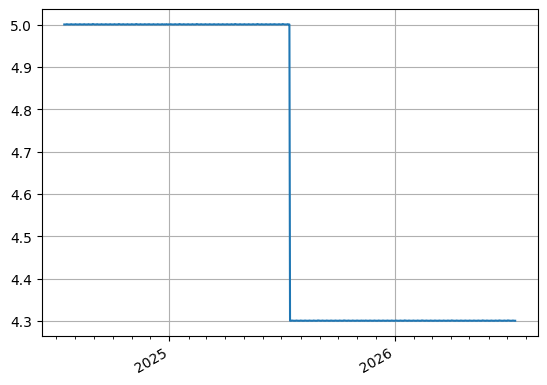

In [15]:
curve = curve_from_zero_rates(
    {dt(2024, 7, 15): 0.0, dt(2025, 7, 15): 5.00, dt(2026, 7, 15): 4.65},
    convention="act365f",
    calendar="nyc",
)
curve.plot("1d")

In [16]:
curve.nodes

{datetime.datetime(2024, 7, 15, 0, 0): 1.0,
 datetime.datetime(2025, 7, 15, 0, 0): 0.951229424500714,
 datetime.datetime(2026, 7, 15, 0, 0): 0.9111935002961405}

If cubic spline interpolation was required this could be included within the ``curve_from_zero_rates`` function using the ``t`` argument from a ``Curve``.

# Using a Solver

The advantage of using a ``Solver`` is that the ``Curve`` can be calibrated directly without a manually written construction function and derivatives and risk sensitivities are automatically obtained. The easiest way to directly specify this is to use the ``Value`` class. 

In [20]:
curve = Curve(
    {dt(2024, 7, 15): 1.0, dt(2025, 7, 15): 1.0, dt(2026, 7, 15): 1.0},
    convention="act365f", calendar="nyc", id="ccz_curve"
)
solver = Solver(
    curves=[curve],
    instruments=[
        Value(dt(2025, 7, 15), "act365f" ,metric="cc_zero_rate", curves=curve),
        Value(dt(2026, 7, 15), "act365f" ,metric="cc_zero_rate", curves=curve),
    ],
    s=[5.0, 4.65]  # <- Same rates to observe same derived discount factors
)

SUCCESS: `func_tol` reached after 4 iterations (levenberg_marquardt), `f_val`: 7.99937338613464e-16, `time`: 0.0010s


(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 [<matplotlib.lines.Line2D at 0x1bfd20f15b0>])

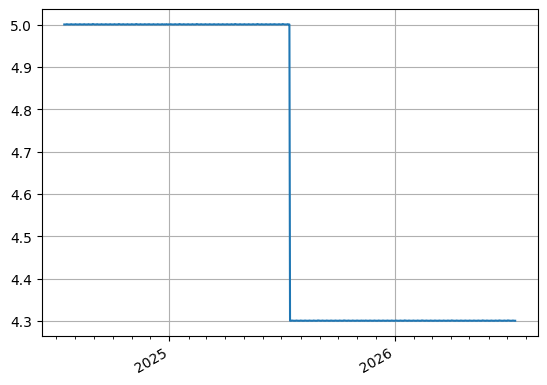

In [21]:
curve.plot("1d")

In [22]:
curve.nodes

{datetime.datetime(2024, 7, 15, 0, 0): <Dual: 1.000000, (ccz_curve0, ccz_curve1, ccz_curve2), [1.0, 0.0, 0.0]>,
 datetime.datetime(2025, 7, 15, 0, 0): <Dual: 0.951229, (ccz_curve0, ccz_curve1, ccz_curve2), [0.0, 1.0, 0.0]>,
 datetime.datetime(2026, 7, 15, 0, 0): <Dual: 0.911194, (ccz_curve0, ccz_curve1, ccz_curve2), [0.0, 0.0, 1.0]>}